In [2]:
from Bio.PDB import PDBParser
import numpy as np
import gudhi
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from Bio.PDB.MMCIFParser import MMCIFParser

## Hemoglobin Stucture
Using .pdb files that provide a representation of the 3D structure of Hemoglobin, we can get out a dataframe of coordinates in 3 dimensions with other information included, too. Then we can use the point clouds to apply topological data analysis techniques.

In [3]:
def create_df(structure):
    '''creates python data frame of data from .pdb files of 3D protein structures'''
    structure_list = []
    for model in structure: 
        for chain in model:
            for residue in chain:
                for atom in residue:
                    atom_info = {
                        "Model": model.id,
                        "Chain": chain.id,
                        "Residue_Name": residue.get_resname(),
                        "Residue_ID": residue.get_id()[1],  # Sequence number
                        "Atom_Name": atom.get_name(),
                        "Element": atom.element,
                        "X": atom.coord[0],
                        "Y": atom.coord[1],
                        "Z": atom.coord[2]
                    }
                    structure_list.append(atom_info)
    df = pd.DataFrame(structure_list)
    return df

# Using Entire Point Cloud:

In [4]:
# Sicklecell data 
# CRYSTAL STRUCTURE OF CARBONMONOXY HEMOGLOBIN S (LIGANDED SICKLE CELL HEMOGLOBIN) COMPLEXED WITH GBT440, CO-CRYSTALLIZATION EXPERIMENT
parser1 = PDBParser(QUIET=True)
sicklecell = parser1.get_structure("sicklecell", "data/5e83.pdb")
sicklecell_df = create_df(sicklecell)
sicklecell_point_cloud = sicklecell_df[['X', 'Y', 'Z']].to_numpy() # create point cloud (extract 3 dim coordinates)
sicklecell_rips_complex = gudhi.RipsComplex(points=sicklecell_point_cloud, max_edge_length=8.0) # create rips
sicklecell_simplex_tree = sicklecell_rips_complex.create_simplex_tree(max_dimension=3) # create simplex
sickle_diagram = sicklecell_simplex_tree.persistence(min_persistence=0.5) # create persistence diagram

In [5]:
# deoxygenated hemiglobin data
parser2 = PDBParser(QUIET=True)
deoxy = parser2.get_structure("deoxy", "data/1a3n.pdb") # deoxy
deoxy_df = create_df(deoxy)
deoxy_point_cloud = deoxy_df[['X', 'Y', 'Z']].to_numpy()
deoxy_rips_complex = gudhi.RipsComplex(points=deoxy_point_cloud, max_edge_length=8.0)  
deoxy_simplex_tree = deoxy_rips_complex.create_simplex_tree(max_dimension=3)
deoxy_diagram = deoxy_simplex_tree.persistence(min_persistence=0.5)

In [6]:
# oxygenated hemoglobin data
parser3 = MMCIFParser(QUIET=True)
oxy = parser3.get_structure("oxy1", "data/1hho-assembly1.cif")
oxy_df = create_df(oxy)
oxy1_df = oxy_df[oxy_df["Residue_Name"] != "OXY"] # remove oxygens from point cloud
oxy_point_cloud = oxy_df[['X', 'Y', 'Z']].to_numpy()
oxy_rips_complex = gudhi.RipsComplex(points=oxy_point_cloud, max_edge_length=8.0) 
oxy_simplex_tree = oxy_rips_complex.create_simplex_tree(max_dimension=3)
oxy_diagram = oxy_simplex_tree.persistence(min_persistence=0.5)

## What does this data look like?

In [86]:
display(sicklecell_df.head(), oxy_df.head(), deoxy_df.head())

,Model,Chain,Residue_Name,Residue_ID,Atom_Name,Element,X,Y,Z
0,0,A,VAL,1,N,N,24.471001,15.116000,21.799000
1,0,A,VAL,1,CA,C,25.270000,16.358000,21.725000
2,0,A,VAL,1,C,C,24.497999,17.414000,22.497999
3,0,A,VAL,1,O,O,23.374001,17.757000,22.128000
4,0,A,VAL,1,CB,C,25.504000,16.834999,20.275999


,Model,Chain,Residue_Name,Residue_ID,Atom_Name,Element,X,Y,Z
0,0,A,VAL,1,N,N,35.467999,45.199001,1.983
1,0,A,VAL,1,CA,C,35.657001,46.671001,2.000
2,0,A,VAL,1,C,C,35.687000,47.160000,3.469
3,0,A,VAL,1,O,O,36.784000,47.195999,4.049
4,0,A,VAL,1,CB,C,34.699001,47.344002,0.967


,Model,Chain,Residue_Name,Residue_ID,Atom_Name,Element,X,Y,Z
0,0,A,VAL,1,N,N,10.720,19.523001,6.163
1,0,A,VAL,1,CA,C,10.228,20.761000,6.807
2,0,A,VAL,1,C,C,8.705,20.714001,6.878
3,0,A,VAL,1,O,O,8.164,20.004999,6.015
4,0,A,VAL,1,CB,C,10.602,22.000000,5.966


## Persistence Landscapes

In [74]:
import numpy as np
import gudhi as gd
from gudhi.representations import Landscape
import matplotlib.pyplot as plt


def get_coordinates(df):
    # Extract atomic coordinates as numpy array
    coords = df[["X", "Y", "Z"]].to_numpy()
    return coords


import numpy as np
import gudhi as gd
from gudhi.representations import Landscape


def compute_persistence_landscape_gudhi(
    coords, max_edge_length=20.0, max_dimension=1, resolution=1000, num_landscapes=3
):
    # Build Vietoris-Rips complex
    rips_complex = gd.RipsComplex(points=coords, max_edge_length=max_edge_length)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=max_dimension)

    # Compute persistence
    persistence = simplex_tree.persistence()

    # Extract persistence intervals
    diag0 = simplex_tree.persistence_intervals_in_dimension(0)
    diag1 = simplex_tree.persistence_intervals_in_dimension(1)

    # Combine intervals
    combined_diag = np.vstack((diag0, diag1)) if len(diag1) > 0 else diag0

    # Remove infinite intervals and degenerate intervals
    finite_diag = combined_diag[np.isfinite(combined_diag[:, 1])]
    finite_diag = finite_diag[finite_diag[:, 1] > finite_diag[:, 0]]

    if len(finite_diag) == 0:
        print("Warning: No valid finite persistence intervals.")
        return np.zeros(resolution * num_landscapes)

    # Compute landscape
    landscape = Landscape(num_landscapes=num_landscapes, resolution=resolution)
    landscape_vector = landscape.fit_transform([finite_diag])[
        0
    ]  # Get first (and only) sample's vector

    return landscape_vector

Persistence landscape vector shape: (3000,)


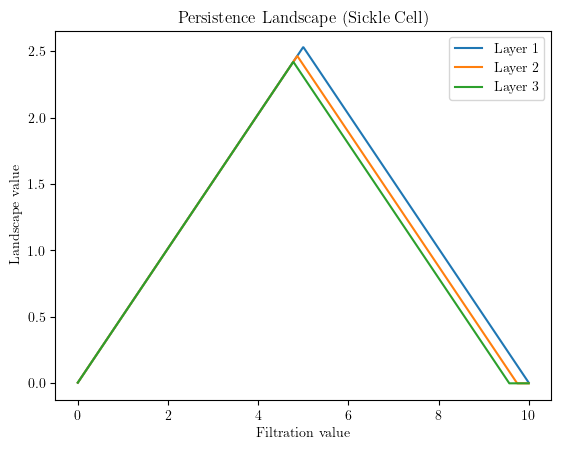

In [75]:
sickle_coords = get_coordinates(sicklecell_df)
sickle_vector = compute_persistence_landscape_gudhi(sickle_coords)

print("Persistence landscape vector shape:", sickle_vector.shape)

resolution = 1000
num_layers = 3
x_vals = np.linspace(0, 10.0, resolution)  # adjust if your filtration range is known

for i in range(num_layers):
    y_vals = sickle_vector[i * resolution : (i + 1) * resolution]
    plt.plot(x_vals, y_vals, label=f"Layer {i+1}")
plt.legend()
plt.title("Persistence Landscape (Sickle Cell)")
plt.xlabel("Filtration value")
plt.ylabel("Landscape value")
plt.show()

Persistence landscape vector shape: (3000,)


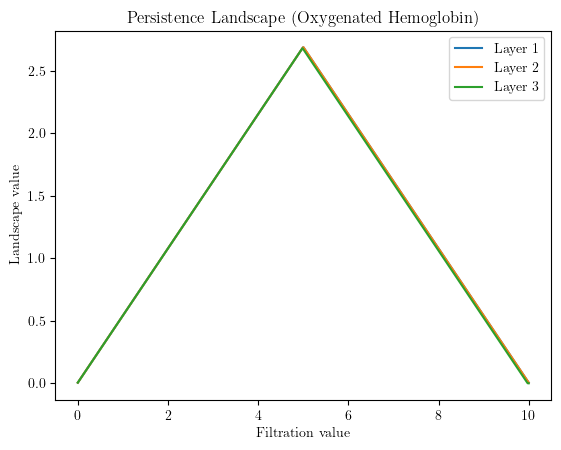

In [76]:
oxy_coords = get_coordinates(oxy_df)
oxy_vector = compute_persistence_landscape_gudhi(oxy_coords)

print("Persistence landscape vector shape:", oxy_vector.shape)

resolution = 1000
num_layers = 3
x_vals = np.linspace(0, 10.0, resolution)  # adjust if your filtration range is known

for i in range(num_layers):
    y_vals = oxy_vector[i * resolution : (i + 1) * resolution]
    plt.plot(x_vals, y_vals, label=f"Layer {i+1}")
plt.legend()
plt.title("Persistence Landscape (Oxygenated Hemoglobin)")
plt.xlabel("Filtration value")
plt.ylabel("Landscape value")
plt.show()

Persistence landscape vector shape: (3000,)


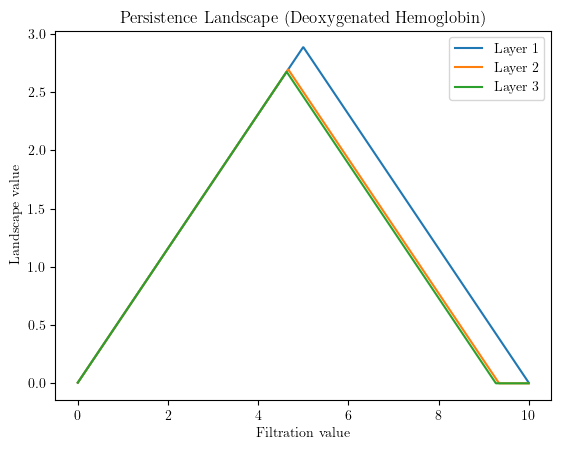

In [77]:
deoxy_coords = get_coordinates(deoxy_df)
deoxy_vector = compute_persistence_landscape_gudhi(deoxy_coords)

print("Persistence landscape vector shape:", deoxy_vector.shape)

resolution = 1000
num_layers = 3
x_vals = np.linspace(0, 10.0, resolution)  # adjust if your filtration range is known

for i in range(num_layers):
    y_vals = deoxy_vector[i * resolution : (i + 1) * resolution]
    plt.plot(x_vals, y_vals, label=f"Layer {i+1}")
plt.legend()
plt.title("Persistence Landscape (Deoxygenated Hemoglobin)")
plt.xlabel("Filtration value")
plt.ylabel("Landscape value")
plt.show()

In [78]:
from scipy.spatial.distance import euclidean

d_sickle_deoxy = euclidean(sickle_vector.flatten(), deoxy_vector.flatten())
d_sickle_oxy = euclidean(sickle_vector.flatten(), oxy_vector.flatten())
d_deoxy_oxy = euclidean(deoxy_vector.flatten(), oxy_vector.flatten())

print(f"Sickle vs Deoxy: {d_sickle_deoxy}")
print(f"Sickle vs Oxy:   {d_sickle_oxy}")
print(f"Deoxy vs Oxy:    {d_deoxy_oxy}")

Sickle vs Deoxy: 9.317079668716337
Sickle vs Oxy:   9.089320236790314
Deoxy vs Oxy:    10.091266637313314


## Some more TDA techniques
After processing each file, we can create persistence diagrams using the Gudhi library

Text(0.5, 1.0, 'Persistence Diagram Sickle')

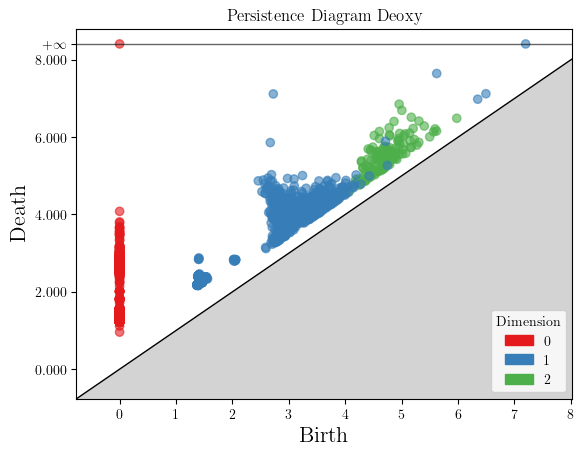

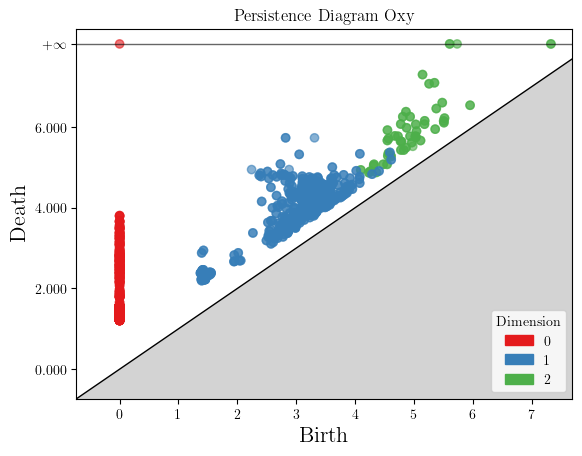

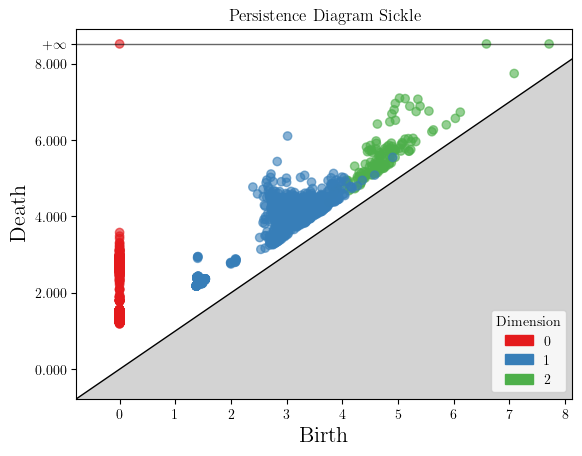

In [79]:
# create persistence diagrams (3 dimensions)
gudhi.plot_persistence_diagram(deoxy_diagram)
plt.title("Persistence Diagram Deoxy")

gudhi.plot_persistence_diagram(oxy_diagram)
plt.title("Persistence Diagram Oxy")

gudhi.plot_persistence_diagram(sickle_diagram)
plt.title("Persistence Diagram Sickle")

Text(0.5, 1.0, 'Persistence Barcode Sickle')

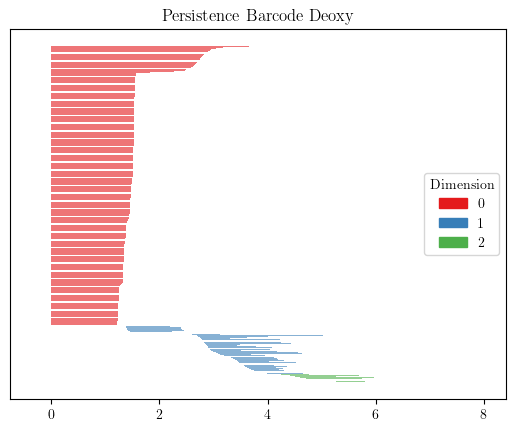

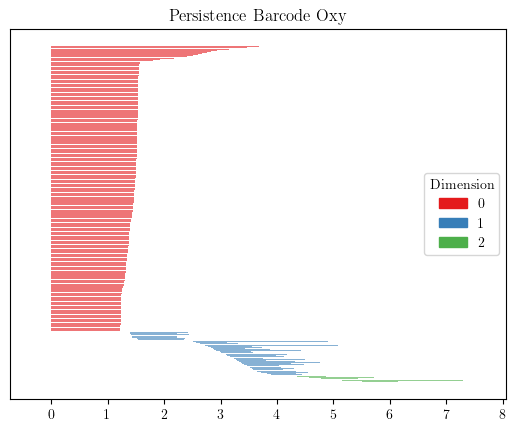

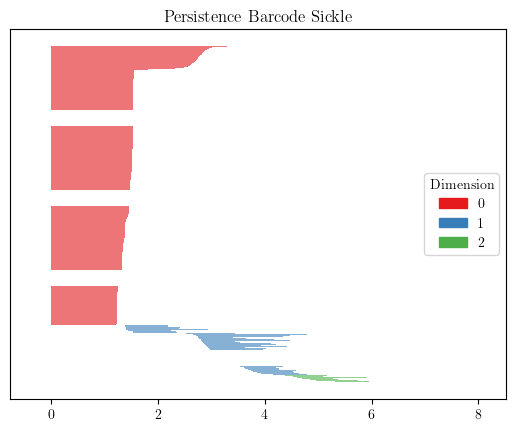

In [80]:
# create persistence barcodes (3 dimensions)
gudhi.plot_persistence_barcode(deoxy_diagram)
plt.title("Persistence Barcode Deoxy")

gudhi.plot_persistence_barcode(oxy_diagram)
plt.title("Persistence Barcode Oxy")

gudhi.plot_persistence_barcode(sickle_diagram)
plt.title("Persistence Barcode Sickle")

In [81]:
# Bottleneck Distances
def bottleneck_distances(d1, d2, p=False, d1_name="", d2_name=""):
    distances = []
    for i in range(3):
        d1_pairs = np.array([pair for dim, pair in d1 if dim == i])
        d2_pairs = np.array([pair for dim, pair in d2 if dim == i])
        # get rid of inf values
        d1_noinf = d1_pairs[~np.isinf(d1_pairs).any(axis=1)]
        d2_noinf = d2_pairs[~np.isinf(d2_pairs).any(axis=1)]
        distances.append(gudhi.bottleneck_distance(d1_noinf, d2_noinf))
    if p == True:
        print(f"Bottleneck distances between {d1_name} and {d2_name}:")
        for i in range(3):
            print(f"\tDimension {i}:", distances[i])
    return distances

# want to compare oxygenated hemiglobin and sicklecell hemi because CO bound to sites on sicklecell, O2 bound on oxy sites
bottleneck_sickle_deoxy = bottleneck_distances(oxy_diagram, sickle_diagram, p=True, d1_name="deoxy hemoglobin", d2_name="sicklecell hemoglobin")
bottleneck_sickle_deoxy = bottleneck_distances(deoxy_diagram, oxy_diagram, p=True, d1_name="deoxy hemoglobin", d2_name="oxygenated hemoglobin")

Bottleneck distances between deoxy hemoglobin and sicklecell hemoglobin:
	Dimension 0: 1.1423795230558764
	Dimension 1: 0.6073384220479427
	Dimension 2: 0.3299873048157931
Bottleneck distances between deoxy hemoglobin and oxygenated hemoglobin:
	Dimension 0: 1.1514849480036637
	Dimension 1: 1.3829076665140612
	Dimension 2: 0.6686509901140765


# Using Residue Point Cloud:

In [82]:
sicklecell_point_cloud_res = sicklecell_df.groupby("Residue_ID")[["X", "Y", "Z"]].mean().to_numpy() # create point cloud (extract 3 dim coordinates)
sicklecell_rips_complex_res = gudhi.RipsComplex(points=sicklecell_point_cloud_res, max_edge_length=10) # create rips
sicklecell_simplex_tree_res = sicklecell_rips_complex_res.create_simplex_tree(max_dimension=3) # create simplex
sickle_diagram_res = sicklecell_simplex_tree_res.persistence(min_persistence=0.01) # create persistence diagram

In [83]:
# deoxygenated hemiglobin data
deoxy_point_cloud_res = deoxy_df.groupby("Residue_ID")[["X", "Y", "Z"]].mean().to_numpy()
deoxy_rips_complex_res = gudhi.RipsComplex(points=deoxy_point_cloud_res, max_edge_length=10.0)  
deoxy_simplex_tree_res = deoxy_rips_complex_res.create_simplex_tree(max_dimension=3)
deoxy_diagram_res = deoxy_simplex_tree_res.persistence(min_persistence=0.01)

In [84]:
# oxygenated hemoglobin data
oxy_point_cloud_res = oxy_df.groupby("Residue_ID")[["X", "Y", "Z"]].mean().to_numpy()
oxy_rips_complex_res = gudhi.RipsComplex(points=oxy_point_cloud_res, max_edge_length=10.0) 
oxy_simplex_tree_res = oxy_rips_complex_res.create_simplex_tree(max_dimension=3)
oxy_diagram_res = oxy_simplex_tree_res.persistence(min_persistence=0.01)

Text(0.5, 1.0, 'Persistence Barcode Sickle')

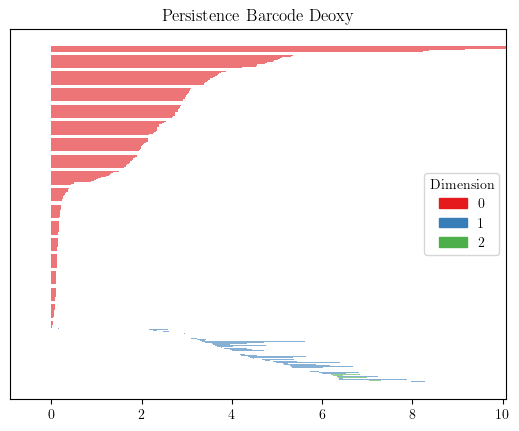

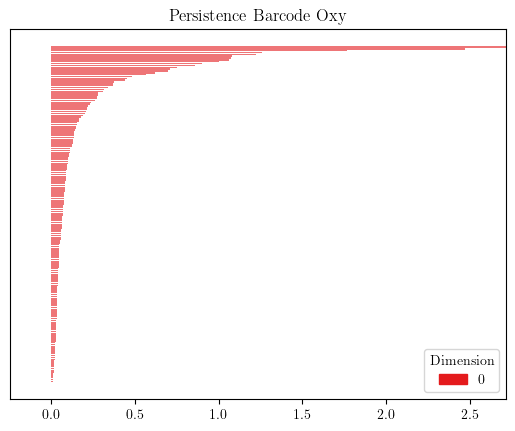

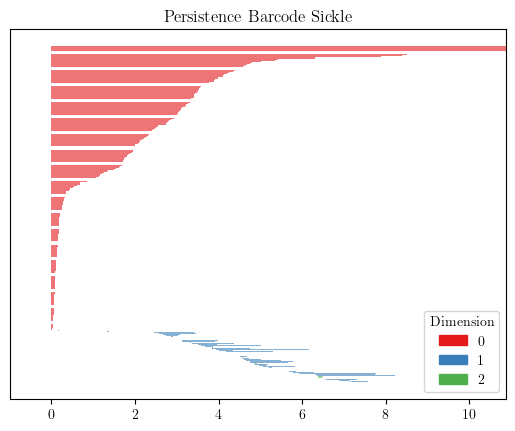

In [85]:
# create persistence barcodes (3 dimensions)
gudhi.plot_persistence_barcode(deoxy_diagram_res)
plt.title("Persistence Barcode Deoxy")

gudhi.plot_persistence_barcode(oxy_diagram_res)
plt.title("Persistence Barcode Oxy")

gudhi.plot_persistence_barcode(sickle_diagram_res)
plt.title("Persistence Barcode Sickle")